# Sign Language Image Classification with a Convolutional Neural Network
By Jens Lichter, Quentin Seifert and Anton Thielmann

## Preperation

### Load recquired packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf  # tensorflow 2.0
import matplotlib.pyplot as plt
import string
import seaborn
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


### Define arguments

We define some values that can be custmized by the user. They are written in all caps so the user can easily see at what points these values play a role.

In [2]:
VAL_SIZE = 0.2
INIT_STDDEV = 0.01
EPOCHS = 50
BATCH_SIZE = 100
KEEP_PROB = 0.7
ROTATE = True
VERTICAL = True
BRIGHT = True
MIXL1L2 = 0
LAMBDA = 0

### Data preperation

(Make sure the paths are correct!)

In [12]:
# load data
train = pd.read_csv('../sign-language-mnist/sign_mnist_train.csv')
test = pd.read_csv('../sign-language-mnist/sign_mnist_test.csv')

# dictonary for numbers of the labels
un_labels = np.unique(train.iloc[:, 0])
letters = np.delete(np.array(list(string.ascii_uppercase[0:25])), 9)
s = pd.Series(letters, index=un_labels)
dict_letters = s.to_dict()

# dictionary for prediction -> delete entry with j
s = pd.Series(letters)
dict_pred = s.to_dict()

# Since our target variable are in categorical(nomial) - binarize the labels
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(train['label'].values)
y_test = label_binarizer.fit_transform(test['label'].values)

# drop the labels from training dataset - first column
train.drop('label', axis=1, inplace=True)
test.drop('label', axis=1, inplace=True)

# Reshape the images
x_train = train.values
x_test = test.values


# split training data to training and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=VAL_SIZE, random_state=101)

#### Helper functions for data augmentation

In [13]:
def rotation(data_x, data_y, angle, size):
    rotate = ImageDataGenerator(rotation_range=angle)
    rotate.fit(data_x)
    for x_rot, y_rot in rotate.flow(data_x, data_y, batch_size=size, shuffle=True):
        break
    return x_rot, y_rot


def vertical_shift(data_x, data_y, range, size):
    vertical = ImageDataGenerator(width_shift_range=range)
    vertical.fit(data_x)
    for x_vert, y_vert in vertical.flow(data_x, data_y, batch_size=size, shuffle=True):
        break
    return x_vert, y_vert

def brightness_change(data_x, data_y, range, size):
    brightness = ImageDataGenerator(brightness_range=range)
    brightness.fit(data_x)
    for x_bright, y_bright in brightness.flow(data_x, data_y, batch_size=size, shuffle=True):
        break
    return x_bright, y_bright

If the according arguments are set to `True` the following cell will augment the training data.

In [14]:
if ROTATE==True:
    #reshape images for rotation function
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    #rotate images and append to complete data
    from data_augmentation import rotation
    images_new, labels_new = rotation(x_train, y_train, angle=30, size=2000)
    x_train = np.concatenate((x_train, images_new), axis=0)
    y_train = np.concatenate((y_train, labels_new), axis=0)
    #reshape images for test split
    x_train = np.array([i.flatten() for i in x_train])

if VERTICAL==True:
    #reshape images into format for vertical_shift functionx_train, y_train
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    #shift images vertically and append to complete data
    from data_augmentation import vertical_shift
    images_new, labels_new = vertical_shift(x_train, y_train, range=[-5,5], size=2000)
    x_train = np.concatenate((x_train, images_new), axis=0)
    y_train = np.concatenate((y_train, labels_new), axis=0)
    #reshape images for test split
    x_train = np.array([i.flatten() for i in x_train])

if BRIGHT==True:
    #reshape images into format for vertical_shift functionx_train, y_train
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    #shift images vertically and append to complete data
    from data_augmentation import brightness_change
    images_new, labels_new = brightness_change(x_train, y_train, range=[0.2, 0.9], size=2000)
    x_train = np.concatenate((x_train, images_new), axis=0)
    y_train = np.concatenate((y_train, labels_new), axis=0)
    #reshape images for test split
    x_train = np.array([i.flatten() for i in x_train])

### Define helper functions for CNN

In this section we define helper functions in order to make the construction of our network more comprehensible 

In [15]:
# weights for convolutional layers - initialized randomly with truncated normal
def weight_variable(shape):
    initial = tf.random.truncated_normal(shape, stddev=INIT_STDDEV)
    return(tf.Variable(initial))

# bias in convolutional layers
def bias_variable(shape):
    initial = tf.constant(0.01, shape=shape)
    return(tf.Variable(initial))

# specify convolution we are using (full convolution)
def conv2d(x, W):
    return(tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME'))

# max pool, using 2x2 batches of the feature map
def max_pool_2x2(x):
    return(tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME'))

# linear convolution with bias, followed by ReLU nonlinearity
def conv_layer(input, shape):
    W = weight_variable(shape)
    b = bias_variable([shape[3]])
    return([tf.nn.relu(conv2d(input, W) + b), W])

# standard fully connected layer with bias
def full_layer(input, size):
    in_size = int(input.get_shape()[1])
    W = weight_variable([in_size, size])
    b = bias_variable([size])
    return([tf.matmul(input, W) + b, W])

# define own next_batch function from MNIST
def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

### Construction of the final model

In [16]:
# enable eager execution
tf.compat.v1.disable_eager_execution()

# Define Placeholders for images, labels and keep prob
x = tf.compat.v1.placeholder(tf.float32, shape=[None, 784], name='x')
y_ = tf.compat.v1.placeholder(tf.float32, shape=[None, 24], name='y_')
keep_prob = tf.compat.v1.placeholder(tf.float32, name='keep_prob')

# reshape image data into 2D image format with size 28x28x1, 28x28 pixels in one channel
x_image = tf.reshape(x, [-1, 28, 28, 1])

# two layers of convolution and pooling, using 16 and 32 filters respectively
conv1, weights_1 = conv_layer(x_image, shape=[3, 3, 1, 16])
conv1_pool = max_pool_2x2(conv1)
conv1_pool = tf.compat.v1.nn.dropout(conv1_pool, rate=1-keep_prob)

conv2, weights_2 = conv_layer(conv1_pool, shape=[3, 3, 16, 32])
conv2_pool = max_pool_2x2(conv2)
conv2_pool = tf.compat.v1.nn.dropout(conv2_pool, rate=1-keep_prob)

# fully connected layer, activate with relu
conv1_flat = tf.reshape(conv2_pool, [-1, 7*7*32])
full_0, weights_3 = full_layer(conv1_flat, 256)
full_1 = tf.nn.relu(full_0)

# rate set to 1-keep_prob
full1_drop = tf.compat.v1.nn.dropout(full_1, rate=1 - keep_prob)

# output = fully connected layer with 24 units(labels of handsigns)
y_conv, weights_4 = full_layer(full1_drop, 24)
y_pred = tf.argmax(y_conv, 1, name='y_pred')

# calculate loss by using softmax on logit model and apply cross entropy
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))

# add regularisation penalties
l1 = tf.reduce_sum(tf.abs(weights_1)) + tf.reduce_sum(tf.abs(weights_2)) \
     + tf.reduce_sum(tf.abs(weights_3)) + tf.reduce_sum(tf.abs(weights_4))
l2 = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) \
     + tf.nn.l2_loss(weights_3) + tf.nn.l2_loss(weights_4)
shrinkage = tf.reduce_mean(cross_entropy + MIXL1L2 * LAMBDA * l1 + (1 - MIXL1L2) * LAMBDA * l2)

# optimization with Adams optimizer
train_step = tf.compat.v1.train.AdamOptimizer(1e-4).minimize(shrinkage)

# predict values and get accuracy
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# create model saver
saver = tf.compat.v1.train.Saver()

### Execution phase

In [17]:
# start session and run model
with tf.compat.v1.Session() as sess:

    # initialize weights and biases and set iteration length
    sess.run(tf.compat.v1.global_variables_initializer())
    num_tr_iter = int(len(y_train) / BATCH_SIZE)
    global_step = 0

    # loop through epochs
    for epoch in range(EPOCHS):
        print(f"Training epoch:  {epoch + 1}")

        # loop through iterations while calculating loss and accuracy for each
        for i in range(num_tr_iter):
            global_step += 1
            start = i * BATCH_SIZE
            end = (i + 1) * BATCH_SIZE
            batch_xs, batch_ys = get_next_batch(x_train, y_train, start, end)

            sess.run(train_step, feed_dict={x: batch_xs,
                                            y_: batch_ys,
                                            keep_prob: KEEP_PROB})

            # after 100 iterations calculate and display the batch loss and accuracy
            if i % 100 == 0:
                loss_batch, acc_batch = sess.run([cross_entropy, accuracy], feed_dict={x: batch_xs,
                                                                                      y_: batch_ys,
                                                                                      keep_prob: 1.0})


                print(f"iter {i:3d}:\t Loss={loss_batch:.3f},\tTraining Accuracy={acc_batch:.5%}")

        # Run validation after every epoch
        loss_valid, acc_valid = sess.run([cross_entropy, accuracy], feed_dict={x: x_val,
                                                                      y_: y_val,
                                                                      keep_prob: KEEP_PROB})
        print('---------------------------------------------------------')
        print(f"Epoch: {epoch + 1}, validation loss: {loss_valid:.3f}, validation accuracy: {acc_valid:.5%}")
        print('---------------------------------------------------------')

        # implement early stopping
        if epoch == 0:
            if not os.path.exists('./trained_model'):
                os.makedirs('./trained_model')
            saver.save(sess, './trained_model/model')
            best_loss_valid = loss_valid
            continue

        if loss_valid < best_loss_valid:
            best_loss_valid = loss_valid
            saver.save(sess, './trained_model/model')

        if (loss_valid / best_loss_valid - 1) * 100 > 4:
            saver.restore(sess, './trained_model/model')
            print('---------------------------------------------------------')
            print('\t \t \t STOPPING EARLY')
            print('---------------------------------------------------------')
            break




    # test model performance on test data
    test_accuracy = np.mean([sess.run(accuracy,
                                      feed_dict={x: x_test,
                                                 y_: y_test,
                                                 keep_prob: 1.0})])

print(f"test accuracy: {test_accuracy:.5%}")

Training epoch:  1
iter   0:	 Loss=3.173,	Training Accuracy=9.00000%
iter 100:	 Loss=3.122,	Training Accuracy=7.00000%
iter 200:	 Loss=2.456,	Training Accuracy=32.00000%
---------------------------------------------------------
Epoch: 1, validation loss: 2.564, validation accuracy: 25.20488%
---------------------------------------------------------
Training epoch:  2
iter   0:	 Loss=2.523,	Training Accuracy=28.00000%
iter 100:	 Loss=1.766,	Training Accuracy=53.00000%
iter 200:	 Loss=1.523,	Training Accuracy=64.00000%
---------------------------------------------------------
Epoch: 2, validation loss: 1.960, validation accuracy: 39.77418%
---------------------------------------------------------
Training epoch:  3
iter   0:	 Loss=1.859,	Training Accuracy=57.00000%
iter 100:	 Loss=1.102,	Training Accuracy=72.00000%
iter 200:	 Loss=0.977,	Training Accuracy=80.00000%
---------------------------------------------------------
Epoch: 3, validation loss: 1.411, validation accuracy: 55.67292%
-

iter 100:	 Loss=0.009,	Training Accuracy=100.00000%
iter 200:	 Loss=0.007,	Training Accuracy=100.00000%
---------------------------------------------------------
Epoch: 24, validation loss: 0.147, validation accuracy: 95.28319%
---------------------------------------------------------
Training epoch:  25
iter   0:	 Loss=0.012,	Training Accuracy=100.00000%
iter 100:	 Loss=0.013,	Training Accuracy=100.00000%
iter 200:	 Loss=0.005,	Training Accuracy=100.00000%
---------------------------------------------------------
Epoch: 25, validation loss: 0.132, validation accuracy: 96.02987%
---------------------------------------------------------
Training epoch:  26
iter   0:	 Loss=0.011,	Training Accuracy=100.00000%
iter 100:	 Loss=0.010,	Training Accuracy=100.00000%
iter 200:	 Loss=0.005,	Training Accuracy=100.00000%
---------------------------------------------------------
Epoch: 26, validation loss: 0.125, validation accuracy: 96.12092%
--------------------------------------------------------

## Visualize Results

### Define helper functions for plots

In [18]:
# write functions for plotting correct and incorrect examples
def plot_images(images, cls_true, cls_pred=None, title=None):

    fig, axes = plt.subplots(2, 2, figsize=(6, 6))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(28, 28), cmap='binary')

        # Show true and predicted classes.
        ax_title = f"True:{dict_pred[cls_true[i]]}  -  Pred: {dict_pred[cls_pred[i]]}"

        ax.set_title(ax_title)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    if title:
        plt.suptitle(title, size=20)
    plt.show(block=False)
    
def plot_example_errors(images, cls_true, cls_pred, title=None):

    # retrieve incorrectly classified pics
    incorrect = np.logical_not(np.equal(cls_pred, cls_true))

    incorrect_images = images[incorrect]

    # Get the true and predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    cls_true = cls_true[incorrect]

    # Plot the first 4 images.
    plot_images(images=incorrect_images,
                cls_true=cls_true,
                cls_pred=cls_pred,
                title=title)

### Examples of correctly and falsely classified images
We use our trained network to predict the test dataset. The following cell shows some examples of correctly and incorrectly classified images.

INFO:tensorflow:Restoring parameters from ./trained_model/model


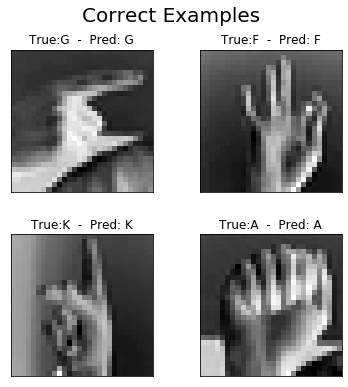

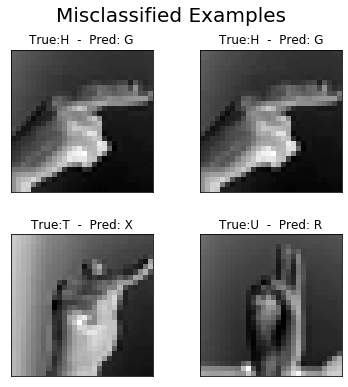

In [20]:
with tf.compat.v1.Session() as sess:
    saver.restore(sess, './trained_model/model')
    cls_pred = sess.run(y_pred, feed_dict={x: x_test, y_: y_test, keep_prob: 1.0})
    
y_lab = []

for i in range(y_test.shape[0]):
    y_lab.append(np.argmax(y_test[i,]))

y_lab = np.array(y_lab)
# plot correct and incorrect predicted examples
cls_true = np.argmax(y_test, axis=1)
plot_images(x_test, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(x_test, cls_true, cls_pred, title='Misclassified Examples')

    

### Confusion matrix
Using the predictions from before, we create a confusion matrix. As the name already suggests, the confusion matrix illustrates which letters are 'confused' with others. Given our high test accuracy, it is not surprising that most of the letters are classified correctly.

INFO:tensorflow:Restoring parameters from ./trained_model/model


Text(0.5, 195.0, 'Predicted label')

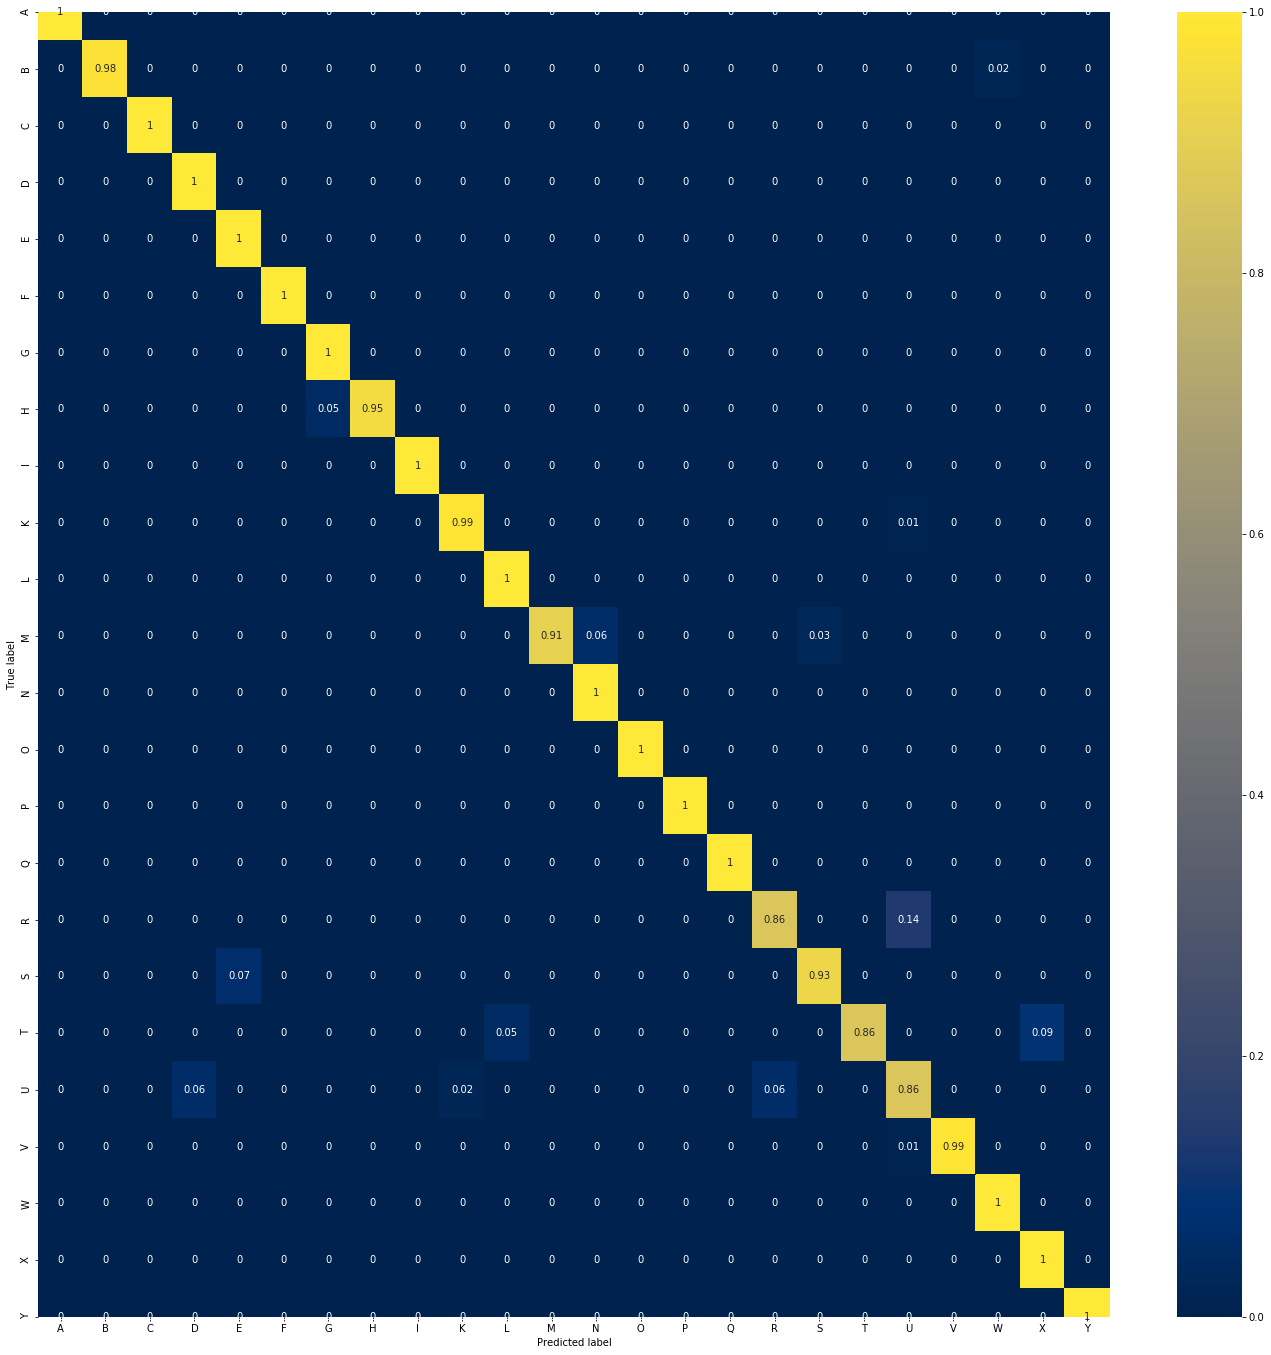

In [22]:
confusion = tf.math.confusion_matrix(y_lab, cls_pred,
                                     num_classes=24, weights=None, dtype=tf.dtypes.int32, name=None)

with tf.compat.v1.Session() as sess:
    saver.restore(sess, './trained_model/model')
    x = sess.run(confusion)
    
x = np.around(x.astype('float') / x.sum(axis=1)[:, np.newaxis], decimals=2)
x_df = pd.DataFrame(x,
                    index=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
                           'S', 'T', 'U', 'V', 'W', 'X', 'Y'],
                    columns=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
                             'S', 'T', 'U', 'V', 'W', 'X', 'Y'])

figure = plt.figure(figsize=(24, 24))
seaborn.heatmap(x_df, annot=True, cmap='cividis')
#plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')